In [28]:
# packages setup
import sys
import os
sys.path.append(os.environ["HOME"]+"/.local/lib/python3.9/site-packages")
import scanpy as sc, anndata as ad
import leidenalg
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.spatial.distance import pdist, squareform

In [62]:
DATADIR=os.environ["HOME"]+"/public/lab6" #defining dir path
dataset = sc.read_10x_mtx(DATADIR, prefix="GSM5114461_S6_A11_", cache=True)
DATADIR=os.environ["HOME"]+"/public/lab6"
dsets = ["GSM5114461_S6_A11", "GSM5114464_S7_D20"] #GSM5114474_M3_E7
adatas = {}
for ds in dsets:
    print(ds)
    adatas[ds] = sc.read_10x_mtx(DATADIR, prefix=ds+"_", cache=True)
combined = ad.concat(adatas, label="dataset")
combined.obs_names_make_unique()

GSM5114461_S6_A11
GSM5114464_S7_D20


In [63]:
# Filter cells by minimum number of genes
sc.pp.filter_cells(combined, min_genes=200)

# Filter cells by minimum counts
sc.pp.filter_cells(combined, min_counts=1000)

# Filter genes by minimum counts
sc.pp.filter_genes(combined, min_counts=15)

# Filter genes by minimum cells
sc.pp.filter_genes(combined, min_cells=5)

In [64]:
combined.var["mt"] = combined.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    combined, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

In [65]:
combined_filt = combined[combined.obs.n_genes_by_counts < 8000, :]
combined_filt =combined_filt[combined_filt.obs.pct_counts_mt < 25, :].copy()

In [66]:
sc.pp.normalize_per_cell(combined_filt, counts_per_cell_after=1e4) # normalize to 10,000 reads/cell
sc.pp.log1p(combined_filt) # log transform

In [67]:
sc.pp.highly_variable_genes(combined_filt,batch_key="dataset",n_top_genes=500)

In [68]:
genes = ["GCG", "TTR",  "IAPP",  "GHRL", "PPY", "COL3A1",
    "CPA1", "CLPS", "REG1A", "CTRB1", "CTRB2", "PRSS2", "CPA2", "KRT19", "INS","SST","CELA3A", "VTCN1"]

combined_var = combined_filt[:, (combined_filt.var.index.isin(genes) | combined_filt.var["highly_variable"])]

In [69]:
sc.pp.pca(combined_var,n_comps=20)

In [70]:
# Import the "external" library
import scanpy.external as sce

# Run harmony using suggested params from the paper
sce.pp.harmony_integrate(combined_var, 'dataset', theta=2, nclust=50,  max_iter_harmony = 10,  max_iter_kmeans=10)

# Reset the original PCs to those computed by Harmony
combined_var.obsm['X_pca'] = combined_var.obsm['X_pca_harmony']

2024-05-24 23:21:09,830 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-05-24 23:21:13,413 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-05-24 23:21:13,703 - harmonypy - INFO - Iteration 1 of 10
2024-05-24 23:21:22,404 - harmonypy - INFO - Iteration 2 of 10
2024-05-24 23:21:31,204 - harmonypy - INFO - Iteration 3 of 10
2024-05-24 23:21:39,501 - harmonypy - INFO - Iteration 4 of 10
2024-05-24 23:21:48,402 - harmonypy - INFO - Iteration 5 of 10
2024-05-24 23:21:57,705 - harmonypy - INFO - Iteration 6 of 10
2024-05-24 23:22:06,705 - harmonypy - INFO - Iteration 7 of 10
2024-05-24 23:22:15,302 - harmonypy - INFO - Iteration 8 of 10
2024-05-24 23:22:22,606 - harmonypy - INFO - Iteration 9 of 10
2024-05-24 23:22:31,901 - harmonypy - INFO - Iteration 10 of 10
2024-05-24 23:22:38,404 - harmonypy - INFO - Stopped before convergence


In [59]:
#sc.pp.subsample(combined_var,n_obs=500) #running tsne on subsample of 500 cells @nim remove this line for whole dataset

In [71]:
combined_var.obs

,dataset,n_genes,n_counts,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
AAACCTGAGAAGGACA,GSM5114461_S6_A11,2541,6850.0,2540,6850.0,322.0,4.700730
AAACCTGAGTAAGTAC,GSM5114461_S6_A11,2346,4500.0,2345,4500.0,142.0,3.155555
AAACCTGGTCCCGACA,GSM5114461_S6_A11,3225,8751.0,3225,8751.0,576.0,6.582105
AAACCTGTCCTAAGTG,GSM5114461_S6_A11,3477,10510.0,3476,10510.0,448.0,4.262607
AAACCTGTCGCCTGTT,GSM5114461_S6_A11,3431,15078.0,3431,15078.0,853.0,5.657249
...,...,...,...,...,...,...,...
TTTGGTTAGTTGAATG,GSM5114464_S7_D20,1775,4495.0,1774,4495.0,26.0,0.578420
TTTGGTTGTCGCGTCA,GSM5114464_S7_D20,705,1592.0,705,1592.0,3.0,0.188442
TTTGTTGAGGCAGGGA,GSM5114464_S7_D20,4508,15440.0,4506,15440.0,3246.0,21.023317
TTTGTTGAGTGCTCGC,GSM5114464_S7_D20,3076,9189.0,3075,9189.0,516.0,5.615410


**steps**:
1. get similarity matrix between points in original (high dimensional) space
    - get conditional probabilities for each point relative to all other points using a Gaussian  
2. initialization
    - chose random starting points in the lower-dimensional space for each original datapoint and compute a new probability matrix using a Student t-distribution rather than a Guassian, but in the lower dimensional space  
3. mapping 
    - minimize Kullback-Liebler divergence between joint probabilities --> minimize the differences in the probabilities between the similarity matrices of the two spaces

search space defined by [0.01 * standard deviation of the norms for the difference between images i and j, 5 * standard deviation of the norms for the difference between images i and j] divided into 200 equal steps. 

In [61]:
# STEP 2b
# perform grid search to obtain values of sigma based on perplexity (used to get similarities)
def search_sigma(distances, curr, perplexity):
    """
    Obtain σ's based on user's perplexity value.

    Parameters:
        distances (np.ndarray): Array containing the pairwise distances between data points.
        curr (int): Index of current data point.
        perplexity (int): User-specified perplexity value.

    Returns:
        sig (float): The value of σ that satisfies the perplexity condition.
    """
    result = np.inf  # Set first result to be infinity

    norm = np.linalg.norm(distances, axis=1)
    std_norm = np.std(norm)  # Use standard deviation of norms to define search space

    for sig_search in np.linspace(0.01 * std_norm, 5 * std_norm, 200):
        # Equation 1 Numerator
        p = np.exp(-(norm**2) / (2 * sig_search**2))

        # Set p = 0 when i = j
        p[curr] = 0

        # Equation 1 (ε -> 0)
        ε = np.nextafter(0, 1)
        p_new = np.maximum(p / np.sum(p), ε)

        # Handle potential NaNs
        if np.any(np.isnan(p_new)):
           # print(f"Skipping sig_search {sig_search}: p_new contains NaNs")
            continue

        # Shannon Entropy
        p_new = p_new[p_new > 0]  # Avoid log2(0) by filtering out non-positive values
        if len(p_new) == 0:  # Check if p_new is empty after filtering
           # print(f"Skipping sig_search {sig_search}: p_new is empty after filtering")
            continue

        H = -np.sum(p_new * np.log2(p_new))

        # Handle potential NaN in H
        if np.isnan(H):
          #  print(f"Skipping sig_search {sig_search}: H is NaN, p_new: {p_new}")
            continue

        # Get log(perplexity equation) as close to equality
        if np.abs(np.log(perplexity) - H * np.log(2)) < np.abs(result):
            result = np.log(perplexity) - H * np.log(2)
            sig = sig_search

    return sig

In [40]:
# STEP 2a
# compute affinities matrix for X in the original (high-dimensional) space
def get_highdim_affinities(X, perplexity):
    """
    Function to obtain similarities matrix in original high-dimensional space.

    Parameters:
    X (??): Input dataset
    perplexity (int): Perplexity of the joint probability distribution

    Returns:
    P (np.ndarray of shape (number of samples * (num samples - 1) / 2)): Joint probabilities  matrix.
    """ 
    n = len(X)
    #print(n)
    P = np.zeros((n, n))
    
    for i in range(0, n):
        # equation 1 numerator
        difference = X[i] - X
        #print(difference.shape)
        sig_i = search_sigma(difference, i, perplexity) # call search function to get sigma
        norm = np.linalg.norm(difference, axis=1)
        P[i, :] = np.exp(-(norm**2) / (2 * sig_i**2))

        # Set p = 0 when j = i
        np.fill_diagonal(P, 0)

        # compute equation 1
        P[i, :] = P[i, :] / np.sum(P[i, :])

    # Set 0 values to minimum numpy value (ε approx. = 0)
    eps = np.nextafter(0, 1)
    P = np.maximum(P, eps)

#     print("Completed Pairwise Affinities Matrix. \n")

    return P

In [41]:
# STEP 2c
# convert original affinities matrix into joint probabilities (symmetric) affinities matrix
def convert_to_jointprob(P):
    """
    Obtain symmetric affinities matrix from original affinities matrix to be utilized in t-SNE.

    Parameters:
    P (np.ndarray): Input (original) affinity matrix.

    Returns:
    P_symmetric (np.ndarray): Symmetric affinities matrix.

    """
    n = len(P)
    P_symmetric = np.zeros(shape=(n, n))
    for i in range(0, n):
        for j in range(0, n):
            P_symmetric[i, j] = (P[i, j] + P[j, i]) / (2 * n)

    # Set 0 values to minimum numpy value (ε approx. = 0)
    eps = np.nextafter(0, 1)
    P_symmetric = np.maximum(P_symmetric, eps)

    return P_symmetric

In [42]:
# STEP 3a
# sample initial solution in lower-dimensional space
def initialize(X, n_dim: int = 2, initialization: str = "random"):
    """
    Create initial solution for t-SNE either randomly or using PCA.

    Parameters:
        X (np.ndarray): The input data array.
        n_dimensions (int): The number of dimensions for the output solution. Default is 2.
        initialization (str): The initialization method. Can be 'random' or 'PCA'. Default is 'random'.

    Returns:
        soln (np.ndarray): The initial solution for t-SNE.

    Raises:
        ValueError: If the initialization method is neither 'random' nor 'PCA'.
    """

    # sample initial solution 
    if initialization == "random" or initialization != "PCA":
        soln = np.random.normal(loc=0, scale=1e-4, size=(len(X), n_dim))
    elif initialization == "PCA":
        X_centered = X - X.mean(axis=0)
        _, _, Vt = np.linalg.svd(X_centered)
        soln = X_centered @ Vt.T[:, :n_dimensions]
    else:
        raise ValueError("Initialization must be 'random' or 'PCA'")

    return soln

In [43]:
# STEP 3b
# compute affinity matrix in lower-dimensional space
# use a Student t-distribution with 1 df
def get_lowdim_affinities(Y):
    """
    Obtain low-dimensional affinities.

    Parameters:
    Y (np.ndarray): Low-dimensional representation of the data points.

    Returns:
    Q (np.ndarray): The low-dimensional affinities matrix.
    """

    n = len(Y)
    Q = np.zeros(shape=(n, n))

    for i in range(0, n):
        # equation 4 numerator
        difference = Y[i] - Y
        norm = np.linalg.norm(difference, axis=1)
        Q[i, :] = (1 + norm**2) ** (-1)

    # Set p = 0 when j = i
    np.fill_diagonal(Q, 0)

    # equation 4
    Q = Q / Q.sum()

    # Set 0 values to minimum numpy value (ε approx. = 0)
    eps = np.nextafter(0, 1)
    Q = np.maximum(Q, eps)

    return Q

In [44]:
# STEP 4
# compute gradient of the cost function 
# cost function = Kullback-Leibler divergence btwn joint prob distrs in 
# high dimensional space vs low dimensional space
def compute_gradient(P, Q, Y):
    """
    Obtain gradient of cost function at current point Y.

    Parameters:
    P (np.ndarray): The joint probability distribution matrix.
    Q (np.ndarray): The Student's t-distribution matrix.
    Y (np.ndarray): The current point in the low-dimensional space.

    Returns:
    gradient (np.ndarray): The gradient of the cost function at the current point Y.
    """

    n = len(P)

    # Compute gradient
    gradient = np.zeros(shape=(n, Y.shape[1]))
    for i in range(0, n):
        difference = Y[i] - Y
        A = np.array([(P[i, :] - Q[i, :])])
        B = np.array([(1 + np.linalg.norm(difference, axis=1)) ** (-1)])
        C = difference
        gradient[i] = 4 * np.sum((A * B).T * C, axis=0)

    return gradient

In [45]:
# STEP 5: t-SNE
# iterate and optimize low-dimensional mapping
# use gradient descent with momentum
# learning rate controls step size at each iteration
# momentum allows optimization algorithm to gain inertia within search space idk what that means
# early exaggeration: places more emphasis on modeling the very similar points (high values in p_ij from the original space) in the new space 
# early on and thus forming “clusters” of highly similar points
def diSNE(adata, perplexity, T, learning_rate: int = 200, early_exaggeration: int = 4, n_dim: int = 2):
    """
    t-SNE (t-Distributed Stochastic Neighbor Embedding) algorithm implementation.

    Args:
        adata (AnnData object): Input AnnData object representing the user's dataset.
        perplexity (int, optional): Perplexity parameter. Default is 10.
        T (int, optional): Number of iterations for optimization. Default is 1000.
        learning_rate (int, optional): Learning rate for updating the low-dimensional embeddings. Default is 200.
        early_exaggeration (int, optional): Factor by which the pairwise affinities are exaggerated
            during the early iterations of optimization. Default is 4.
        n_dim (int, optional): The number of dimensions of the low-dimensional embeddings. Default is 2.

    Returns:
        adata (AnnData object): Updated AnnData object containing the t-SNE results.

    """
    X = adata.obsm['X_pca']
    n = len(X)

    # Get original affinities matrix
    P = get_highdim_affinities(X, perplexity)
    P_symmetric = convert_to_jointprob(P)

    # Initialization
    Y = np.zeros(shape=(T, n, n_dim))
    Y_minus1 = np.zeros(shape=(n, n_dim))
    Y[0] = Y_minus1
    Y1 = initialize(X, n_dim)
    Y[1] = np.array(Y1)

    print("Optimizing Low Dimensional Embedding....")
    # Optimization
    for t in range(1, T - 1):
        # Momentum & Early Exaggeration
        if t < 250:
            momentum = 0.5
            early_exaggeration = early_exaggeration
        else:
            momentum = 0.8
            early_exaggeration = 1

        # Get Low Dimensional Affinities
        Q = get_lowdim_affinities(Y[t])

        # Get Gradient of Cost Function
        gradient = compute_gradient(early_exaggeration * P_symmetric, Q, Y[t])

        # Update Rule
        Y[t + 1] = Y[t] - learning_rate * gradient + momentum * (Y[t] - Y[t - 1])  # Use negative gradient

        # Compute current value of cost function (Kullback-Leibler divergence)
        if t % 100 == 0:
            cost = np.sum(P_symmetric * np.log(P_symmetric / Q))
            print(f"Iteration {t}: Value of Cost Function is {cost}")

    print(
        f"Completed Low Dimensional Embedding: Final Value of Cost Function is {np.sum(P_symmetric * np.log(P_symmetric / Q))}"
    )
    soln = Y[-1]

#     return soln, Y
    adata.obsm['X_tsne'] = soln
    return

In [46]:
# plot t-SNE results 
def plot_tsne_results(adata, feature, title='diSNE results', figsize=(10, 8)):
    tsne_out = adata.obsm['X_tsne']
    labels = adata.obs[feature].astype(int).values
    plt.figure(figsize=figsize)
    scatter = plt.scatter(tsne_out[:, 0], tsne_out[:, 1], c=labels, cmap='viridis', marker='o')
    if labels is not None:
        plt.legend(*scatter.legend_elements(), title="Clusters")
    plt.title(title)
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
#     plt.colorbar()
    plt.show()

In [72]:
#diSNE(combined_var, 10, 1000, 4, 2)
diSNE(combined_var, 50, 100)

/tmp/ipykernel_167/1527008661.py:29: RuntimeWarning: invalid value encountered in true_divide
  p_new = np.maximum(p / np.sum(p), ε)


Optimizing Low Dimensional Embedding....
Completed Low Dimensional Embedding: Final Value of Cost Function is 3.7549969593247385


In [73]:
sc.pp.neighbors(combined_var) # computes neighborhood graphs. Needed to run clustering.
sc.tl.leiden(combined_var)

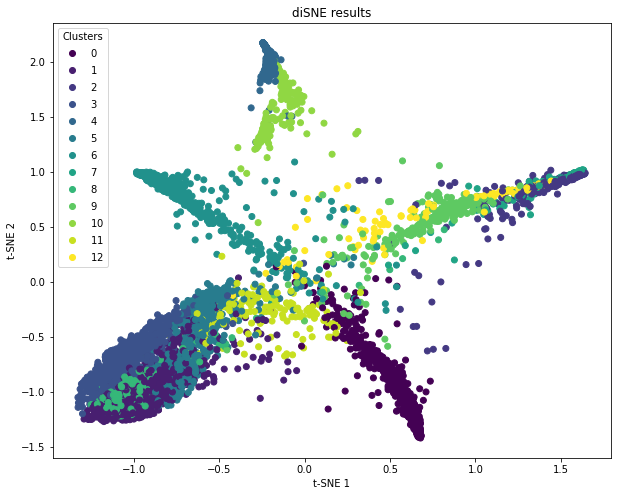

In [74]:
# Extract t-SNE results and cluster labels
tsne_out = combined_var.obsm['X_tsne']
clusters = combined_var.obs['leiden'].astype(int).values  # Cluster labels

# Plot the t-SNE results
plot_tsne_results(combined_var, feature='leiden')

In [ ]:
import hdf5plugin

def save_data_to_h5ad(adata, filename = "./diSNE-results"):
    """
    Save data to an H5AD file format with specified compression settings.

    Parameters:
        adata (Anndata): The Anndata object containing the data.
        filename (str): The name of the file to which the data will be saved.
    """
    compression = hdf5plugin.FILTERS["zstd"]
    compression_opts = hdf5plugin.Zstd(clevel=5).filter_options

    adata.write_h5ad(filename, compression=compression, compression_opts=compression_opts)

In [ ]:
#check if there is a specified filename or not; if there is: 
#adata.write_h5ad(combined_var, filename)
#if there is not and we want to use the default 
adata.write_h5ad(combined_var)

In [ ]:
#saving the plot results to the given directory
def save_tsne_plot(adata, feature, filename = './tsne_plot.png', title='diSNE results', figsize=(10, 8)):
    plot = plot_tsne_results(adata, feature, title, figsize)
    plot.savefig(filename)  # Save the plot to a file

In [ ]:
#if i want to use the default 
save_tsne_plot(combined_var,feature='leiden')
#if i want to use a specified filename: 
#save_tsne_plot(combined_var,feature='leiden', filename)